In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score, median_absolute_error, max_error
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
import itertools
import joblib
import json
import csv

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
model_info = {
    'model_name': 'Decision Tree Classifier',
    'training_file': 'MLM_Decision_Tree_Classifier.ipynb',
    'file_name': 'model_dtc.pkl',
    'scaler_file': 'model_dtc_scaler.pkl',
    'prepared_by': 'Digital Khalid',
    'library': 'Scikit-Learn',
    'algorithm': 'Decision Tree Classifier',
    'normalization': 'Standard Scaler (Z-Score)',
    'data_file': '../../datasets/univ2_flows.csv',
    'features': ['source_port', 'destination_port', 'protocol', 'first_pkt_size'],
    'target': ['flow_class'],
}

In [3]:
# Save model information as json file
with open(f'model_info_{model_info["model_name"]}.json', "w") as outfile:
    json.dump(model_info, outfile)

In [4]:
# Read data file
input_file = model_info['data_file']
input_file
flows = pd.read_csv(input_file)

### Dataset Adjustments

In [5]:
flows['idle_timeout'].value_counts()

idle_timeout
11    13646
0      9547
1      5451
2        72
6        59
3        32
4        30
8        16
9        15
5        14
7        13
10        7
Name: count, dtype: int64

In [6]:
features = model_info['features']
target = model_info['target']

X = flows[features]
y = flows[target]

In [7]:
print(f'features (X)\n{X}')

features (X)
       source_port  destination_port  protocol  first_pkt_size
0             7001              7000        17              86
1             7000              7001        17             108
2             7001              7000        17              86
3             7000              7001        17             190
4             7001              7000        17              86
...            ...               ...       ...             ...
28897        52980              7002        17             107
28898         7001              7003        17              86
28899         7003              7001        17            1118
28900        56059              7002        17             334
28901         7002             56059        17              78

[28902 rows x 4 columns]


In [8]:
print(f'features (y)\n{y}')

features (y)
       flow_class
0               3
1               3
2               3
3               3
4               3
...           ...
28897           1
28898           2
28899           2
28900           2
28901           2

[28902 rows x 1 columns]


In [9]:
# Data Normalization
scaler = StandardScaler()

# Fit the scaler on the training set and transform the training set
X_norm = scaler.fit_transform(X)
X_norm

array([[-0.52138077, -0.48779902,  0.21136645, -0.40665979],
       [-0.52143559, -0.48774281,  0.21136645, -0.29813006],
       [-0.52138077, -0.48779902,  0.21136645, -0.40665979],
       ...,
       [-0.52127113, -0.48774281,  0.21136645,  4.68437117],
       [ 2.16802626, -0.4876866 ,  0.21136645,  0.81676625],
       [-0.52132595,  2.26984203,  0.21136645, -0.44612515]])

In [10]:
joblib.dump(scaler, model_info['scaler_file'])

['model_dtc_scaler.pkl']

In [11]:
flows['flow_class'].value_counts()/ flows.shape[0] * 100

flow_class
1    38.478306
3    31.229673
2    30.292021
Name: count, dtype: float64

### Cost Effective Decision Tree (Balanced)

In [45]:
# define model
model = DecisionTreeClassifier(class_weight='balanced')

In [46]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [52]:
scores = cross_val_score(model, X_norm, y, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   42.9s finished


In [54]:
np.mean(scores)

0.5613046076671847

### Cost Effective Decision Tree (Using multiple class weights and hyperparameters with Grid Search CV)

In [12]:
# define model
model = DecisionTreeRegressor()

NameError: name 'DecisionTreeRegressor' is not defined

In [81]:
# define grid
# balance = [{0:1,1:1000}, {0:1,1:500}, {0:1,1:250}]
# class_weight = [{0:1,1:1500}, {0:1,1:2500}]
max_depth = [5, 10]
min_samples_split = [5, 10]
criterion = ['absolute_error', 'squared_error', 'poisson', 'friedman_mse']
splitter = ['best', 'random']

param_grid = {
    # 'class_weight': class_weight,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'criterion': criterion,
    'splitter': splitter,
}

In [82]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=1, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-3, cv=cv, scoring='neg_mean_squared_error', verbose=3)

In [83]:
# execute the grid search
grid_result = grid.fit(X_norm, y)

Fitting 2 folds for each of 32 candidates, totalling 64 fits


KeyboardInterrupt: 

In [133]:
# report the best configuration
print()
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.970502 using {'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5, 'splitter': 'best'}
0.945225 (0.006527) with: {'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 5, 'splitter': 'best'}
0.879478 (0.021756) with: {'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 5, 'splitter': 'random'}
0.945225 (0.006527) with: {'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 10, 'splitter': 'best'}
0.870731 (0.021427) with: {'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 10, 'splitter': 'random'}
0.945225 (0.006527) with: {'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 15, 'splitter': 'best'}
0.868124 (0.024640) with: {'class_weight': {0: 1, 1: 1500}, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 15, 'splitter': 'random'}
0.97050

### Cost Effective Decision Tree (Using best hyperparameters)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, random_state=1, test_size=0.25, stratify=y)

In [14]:
def test_hyperparameters(class_weight, max_depth, min_sample_split, criterion, splitter, log):
    best_param_grid = {
        'class_weight': class_weight,
        'max_depth': max_depth,
        'min_samples_split': min_sample_split,
        'criterion': criterion,
        'splitter': splitter,
    }
    
    # define model
    model = DecisionTreeClassifier(**best_param_grid)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluate the model's performance
    precision = precision_score(y_test, y_pred, average = 'macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average = 'macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average = 'macro', zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    # fpr, tpr, _ = roc_curve(y_test, y_pred)
    # roc_auc = auc(fpr, tpr)

    log_val = [max_depth, min_sample_split, criterion, splitter, precision, recall, f1, accuracy]
    print(log_val)
    
    if log == True:
        log_file = 'log_dtc_training.csv'
        
        with open(log_file, 'a', newline = '') as logs:
            writer = csv.writer(logs)
            writer.writerow(log_val)

In [15]:
class_weight = ['balanced']
max_depth = [3, 5, 10]
min_sample_split = [3, 5, 10]
criterion = ['gini', 'entropy']
splitter = ['best', 'random']
log = True

for i in class_weight:
    for j in max_depth:
        for k in min_sample_split:
            for l in criterion:
                for m in splitter:
                    test_hyperparameters(i, j, k, l, m, log)

[3, 3, 'gini', 'best', 0.6818409170791826, 0.6814248478458192, 0.67093601830726, 0.6929144755051204]
[3, 3, 'gini', 'random', 0.7685076419895625, 0.6433955734853134, 0.5519457018252489, 0.6663437586493219]
[3, 3, 'entropy', 'best', 0.6568707617230498, 0.6626456455338452, 0.6482967652997027, 0.6752006642679214]
[3, 3, 'entropy', 'random', 0.7572642718343605, 0.6284591078565372, 0.5407121503631585, 0.6487683365624135]
[3, 5, 'gini', 'best', 0.6818409170791826, 0.6814248478458192, 0.67093601830726, 0.6929144755051204]
[3, 5, 'gini', 'random', 0.7638595865136181, 0.6421145343455029, 0.5523132122379826, 0.6657902020481594]
[3, 5, 'entropy', 'best', 0.6568707617230498, 0.6626456455338452, 0.6482967652997027, 0.6752006642679214]
[3, 5, 'entropy', 'random', 0.7477362117610995, 0.6388378358763959, 0.5454653854905671, 0.6616385275394409]
[3, 10, 'gini', 'best', 0.6818409170791826, 0.6814248478458192, 0.67093601830726, 0.6929144755051204]
[3, 10, 'gini', 'random', 0.7562234340818758, 0.6016335297

In [17]:
best_param_grid = {
    'class_weight': 'balanced',
    'max_depth': 10,
    'min_samples_split': 3,
    'criterion': 'gini',
    'splitter': 'best',
}

# define model
model = DecisionTreeClassifier(**best_param_grid)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [115]:
# Evaluate the model's performance
precision = precision_score(y_test, y_pred, average = 'macro', zero_division=0)
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average = 'macro', zero_division=0)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average = 'macro', zero_division=0)
print("F1 Score:", f1)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Precision: 0.7579501070666493
Recall: 0.753193667615748
F1 Score: 0.7443416129165016
Accuracy: 0.7676285378174521


In [75]:
model = joblib.load(model_info['file_name'])

In [76]:
scaler = joblib.load(model_info['scaler_file'])

In [77]:
model.feature_importances_

array([0.4 , 0.37, 0.  , 0.22])

In [78]:
features = model_info['features']
target = model_info['target']

X = flows[features]
y = flows[target]

In [79]:
X_norm = scaler.transform(X)

In [80]:
predictions = model.predict(X_norm)

In [81]:
predictions

array([3, 3, 3, ..., 3, 1, 1])

In [82]:
predictions = pd.Series(predictions, index=X.index)
predictions

0        3
1        3
2        3
3        3
4        3
        ..
28897    1
28898    3
28899    3
28900    1
28901    1
Length: 28902, dtype: int64

In [83]:
pred_flows = pd.concat([X, y, predictions], axis=1)
pred_flows

,source_port,destination_port,protocol,first_pkt_size,flow_class,0
0,7001,7000,17,86,3,3
1,7000,7001,17,108,3,3
2,7001,7000,17,86,3,3
3,7000,7001,17,190,3,3
4,7001,7000,17,86,3,3
...,...,...,...,...,...,...
28897,52980,7002,17,107,1,1
28898,7001,7003,17,86,2,3
28899,7003,7001,17,1118,2,3
28900,56059,7002,17,334,2,1


In [84]:
pred_flows.rename(columns={'idle_timeout': 'actual_idle_timeout'}, inplace=True)

In [85]:
pred_flows.rename(columns={0: 'predicted_class'}, inplace=True)

In [86]:
pred_flows['predicted_class'] = pred_flows['predicted_class'].astype(int)

In [87]:
pred_flows

,source_port,destination_port,protocol,first_pkt_size,flow_class,predicted_class
0,7001,7000,17,86,3,3
1,7000,7001,17,108,3,3
2,7001,7000,17,86,3,3
3,7000,7001,17,190,3,3
4,7001,7000,17,86,3,3
...,...,...,...,...,...,...
28897,52980,7002,17,107,1,1
28898,7001,7003,17,86,2,3
28899,7003,7001,17,1118,2,3
28900,56059,7002,17,334,2,1


In [105]:
y_test = pred_flows['flow_class']
y_pred = pred_flows['predicted_class']

In [106]:
y_test.value_counts()

flow_class
1    11121
3     9026
2     8755
Name: count, dtype: int64

In [107]:
y_pred.value_counts()

predicted_class
1    11764
3    11277
2     5861
Name: count, dtype: int64

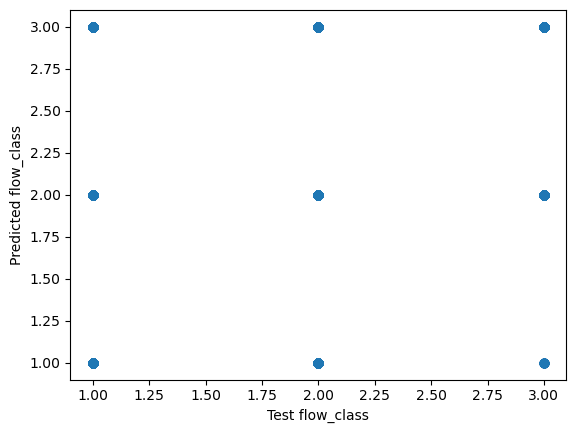

In [108]:
fig, ax = plt.subplots()
ax.set_xlabel('Test ' + target[0])
ax.set_ylabel('Predicted ' + target[0])
ax.scatter(y_test, y_pred)